# Welcome to the microlensing data challenge tutorial

This notebook is intended to provide the framework for non-microlensers to participate in the challenge. It requires installation of the pylima and mulensmodel modules. This combines two notebooks from the Sagan workshop for pyLIMA and muLens tutorial.


In [1]:
## First import the required libraries
#%matplotlib notebook
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
import astropy.units as u
import os
import sys
import time
from scipy.stats import chisquare
from datetime import datetime
start_time = datetime.now() # initialize timer

sys.path.append('/Users/meshkat/python/pylima/pyLIMA-master')
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlcaustics
from pyLIMA import microltoolbox

sys.path.append('/Users/meshkat/python/MulensModel/source')
import MulensModel as mm
from MulensModel.utils import Utils

sys.path.append('/Users/meshkat/python/muLAn')
from muLAn import mulan
##Must copy contents of muLAn/template to the local directory you are running notebook in?


#import check

In [2]:
#parameter definitions, same across all codes except for alpha
to = 2460963.9
uo = 0.45
tE = 24.3
rho = 0.007
s = 10**0.198
q = 10**-3.23
alpha = -0.5 #######in radians

log_s = np.log10(s)
log_q = np.log10(q)

# ***Set time range of planetary perturbation (including 2460000).***
(t_anomaly_start, t_anomaly_stop) = (2460982., 2460985.)

### time when the peak of the anomaly occurs (HJD)
t_anomaly = 2460983.0

### duration of the anomaly in days
delta_t = 1

###define path to file and filename
filename = '/Users/meshkat/python/WFIRST/Microlensing/handson_2017/WFIRST_SAGAN_6/WFIRST_1827.dat'

WFIRST_data = np.loadtxt(filename)
where_inf=np.where(WFIRST_data==np.inf)
WFIRST_data[where_inf]=np.mean((WFIRST_data[where_inf[0][0]-1,where_inf[1][0]],
                                WFIRST_data[where_inf[0][0]+1,where_inf[1][0]]))

In [ ]:
# def goodness_of_fit(data, model):
#     """Find the goodness of fit for the data vs the model"""
    
#     model_diff = (data - model) ** 2
# #     for i,g in enumerate(model_diff):
# #         if g==np.inf: model_diff[i]=np.nan
#     model_diff2=(data - model) ** 2 / model
#     gof=np.nansum(model_diff)/model_diff.shape[0]
#     gof2=np.nansum(model_diff2)
    
#     return gof, gof2

# Pylima

In [3]:
### Plot the event. Select the rectangle to zoom in and inspect the details.
### Note the approximate peak of the planet perturbation in HJD
### you will have to change the file path for your machine.


### Lets have a look at what it is exactly :
figure1 = plt.figure()
plt.errorbar(WFIRST_data[:,0]-2460000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.xlabel('HJD-2460000',fontsize=20)
plt.ylabel('MAG',fontsize=20)
plt.gca().invert_yaxis()
figure1.show()


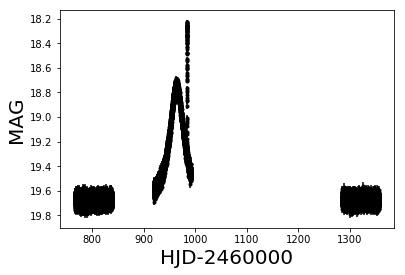

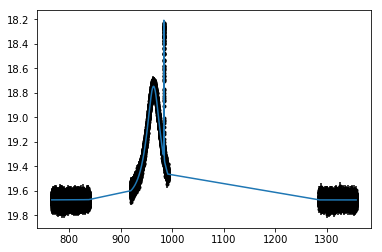

In [4]:
### 


### Create an event object. You can choose the name :

pl_event = event.Event()

###****CHANGE****###
pl_event.name = 'WFIRST_1827'

### We define a telescope object.
wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=WFIRST_data)
###****ENDOFCHANGE****###


pl_event.telescopes.append(wfirst)

### Let's define a binary model, name in pyLIMA is Uniform Source Binary Lens.

binary_model = microlmodels.create_model('USBL', pl_event)
binary_model.define_model_parameters()

### Have a look at your guess. Change these parameters if you want 
estimate_parameters = [to, uo, tE, rho, np.log10(s), np.log10(q), alpha]

pyLIMA_parameters = binary_model.compute_pyLIMA_parameters(estimate_parameters)


pl_model, wfirst_source_flux, wfirst_blend_flux = binary_model.compute_the_microlensing_model(wfirst, pyLIMA_parameters)
model_in_magnitude = microltoolbox.flux_to_magnitude(pl_model)  


plt.figure()
plt.subplot(111)
plt.errorbar(WFIRST_data[:,0]-2460000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.gca().invert_yaxis()
plt.plot(wfirst.lightcurve_flux[:,0]-2460000, model_in_magnitude,zorder=10)
plt.show()


In [5]:
chi_sq_pylima,_=chisquare(WFIRST_data[:-1,1], f_exp=model_in_magnitude)

In [6]:
ModelID_pl='WFIRST_1827.dat_pylima' #Model ID containing both target ID and solution number e.g. [target]_[solution]
t0_pl = 0#round(pl_event.fits[-1].outputs.fit_parameters.to,6) #Time of peak, t0 [days] - priority
sig_t0_pl = 0#pl_event.fits[-1].outputs.fit_errors.err_to #Uncertainty in t0 [days] - priority
tE_pl = 0#round(pl_event.fits[-1].outputs.fit_parameters.tE,6) #Einstein crossing time, tE [days] - priority
sig_tE_pl = 0#pl_event.fits[-1].outputs.fit_errors.err_tE #Uncertainty in tE [days] - priority
u0_pl = 0#round(pl_event.fits[-1].outputs.fit_parameters.uo,6) #Minimum impact parameter, u0 [normalised by θE] - priority
sig_u0_pl =  0#pl_event.fits[-1].outputs.fit_errors.err_uo #Uncertainty in u0 - priority
rho_pl = 0#round(pl_event.fits[-1].outputs.fit_parameters.rho,6) #Angular source size parameter, rho
sig_rho_pl = 0#pl_event.fits[-1].outputs.fit_errors.err_rho #Uncertainty on rho
piEE_pl = 'None'  #Parallax parameter πE,E
sig_piEE_pl = 'None'  #Uncertainty on πE,E
piEN_pl = 'None'  #Parallax parameter πE,N
sig_piEN_pl = 'None'  #Uncertainty on πE,N
fs_pl = 0#round(pl_event.fits[-1].outputs.fit_parameters.fs_WFIRST,6) #Source flux, fs [counts/s] - priority
sig_fs_pl = 0#pl_event.fits[-1].outputs.fit_errors.err_fs_WFIRST #Uncertainty in fs [counts/s] - priority
fb_pl = 'None' #Blend flux, fb [counts/s] - priority
sig_fb_pl = 'None' #Uncertainty in fb [counts/s] - priority
s_pl = 0#10**(pl_event.fits[-1].outputs.fit_parameters.logs) #Binary separation, s, [normalised by θE] - priority
sig_s_pl = 'None' #Uncertainty on s - priority
q_pl = 0#10**(pl_event.fits[-1].outputs.fit_parameters.logq) #Mass ratio, q = M2/M1 - priority
sig_q_pl = 'None' #Uncertainty on q - priority
alpha_pl = 0#pl_event.fits[-1].outputs.fit_parameters.alpha #Angle of lens motion, alpha - priority
sig_alpha_pl = 'None' #Uncertainty on alpha - priority
dsdt_pl = 'None'  #Rate of change of s, ds/dt
sig_dsdt_pl = 'None'  #Uncertainty on ds/dt
dadt_pl =  'None' #Rate of change of alpha, dalpha/dt
sig_dadt_pl = 'None'  #Uncertainty on dalpha/dt
t0_par_pl = 'None'  #t0_par [days]
chisq_pl = chi_sq_pylima #Chi squared of the fitted model
M1_pl = 'None'  #Primary lens mass, M1 [Msolar]
sig_M1_pl = 'None'  #Uncertainty on M1 [Msolar]
M2_pl = 'None'  #Secondary lens mass, M2 [MJupiter] 
sig_M2_pl = 'None'  #Uncertainty on M2 [MJupiter] 
DL_pl = 'None'  #Distance to the lens, DL [kpc]
sig_DL_pl = 'None'  #Uncertainty on DL [kpc]
DS_pl = 'None'  #Distance to the source, DS [kpc]
sig_DS_pl = 'None'  #Uncertainty on DS [kpc]
aperp_pl = 'None'  #Projected separation of lens masses, aperp [AU]
sig_aperp_pl = 'None'  #Uncertainty on aperp [AU]
t_fit_pl = 'None' #Time taken to fit the lightcurve from data ingest to final output [hrs]

# MulensModel

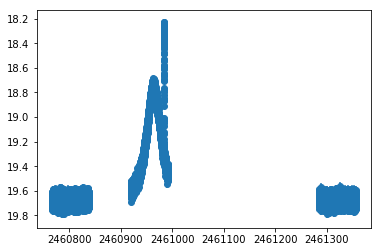

In [7]:
### 
data = mm.MulensData(file_name=filename)

plt.errorbar(data.time, data.mag, yerr=data.err_mag, fmt='o')
plt.gca().invert_yaxis()
plt.show()

In [8]:


# *Set the magnification methods for the planet model*
# VBBL method will be used between t_planet_start and t_planet_stop, 
# and point_source_point_lens will be used everywhere else.
magnification_methods = [
    0., 'point_source_point_lens', 
    t_anomaly_start, 'VBBL', t_anomaly_stop, 
    'point_source_point_lens', 2470000.]

In [9]:
# Flag data related to the planet
flag_planet = (data.time > t_anomaly_start) & (data.time < t_anomaly_stop) | np.isnan(data.err_mag)

# Exclude those data from the fitting (for now)
data.bad = flag_planet

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2460963.90000  0.450000    24.3000 0.00700   1.57761   0.00058884   -28.64789 



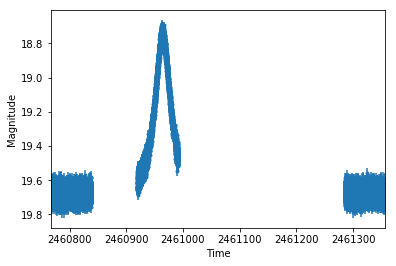

In [10]:
# Check the estimated model
# Note that there are two possibilities for s: s_plus and s_minus. 


# Define the model
mlm_model = mm.Model({
    't_0': to, 
    'u_0': uo,
    't_E': tE,
    'rho': rho,
    's': s,
    'q': q,
    'alpha': np.rad2deg(alpha)})
mlm_model.set_magnification_methods(magnification_methods)
mlm_event = mm.Event(datasets=data, model=mlm_model)
print(mlm_event.model)



mlm_event.plot_data()
plt.show()



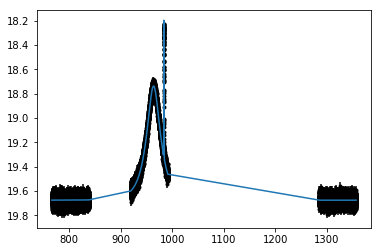

In [11]:
times=WFIRST_data[:,0]


mlm_event.get_chi2()
flux = mlm_event.fit.get_flux(data)


# (f_source, f_blend) = mlm_event.get_ref_fluxes(data_ref=mlm_event.data_ref)
# flux = f_source * test_model.magnification(times) + f_blend


model_in_magnitude0=Utils.get_mag_from_flux(flux)


plt.figure()
plt.subplot(111)
plt.errorbar(WFIRST_data[:,0]-2460000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.gca().invert_yaxis()
plt.plot(times-2460000, model_in_magnitude0,zorder=10)
plt.show()

In [12]:
# gof0,gof02=goodness_of_fit(WFIRST_data[:,1],model_in_magnitude0)
# print gof0,gof02
chi_sq_mulens,_=chisquare(WFIRST_data[:,1],f_exp=model_in_magnitude0)

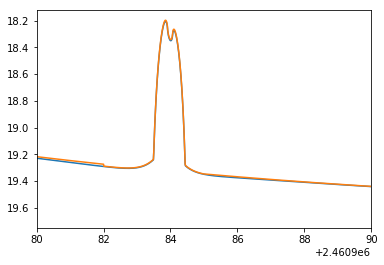

In [13]:
###Just to compare the two models, if you want to see the difference.
plt.plot(times[1:], model_in_magnitude)
plt.plot(times, model_in_magnitude0)
plt.xlim(2460980,2460990)
plt.gca().invert_yaxis()
plt.show()


In [14]:
end_time = datetime.now()
print('Total Runtime: {0}'.format(end_time - start_time))
t= format(end_time - start_time)
(h, m, s) = t.split(':')
hours_to_run = float(h) + float(m) / 60 + float(s) / 3600

Total Runtime: 0:00:42.622321


In [15]:
ModelID_mlm= 'WFIRST_1827.dat_MulensModel' #Model ID containing both target ID and solution number e.g. [target]_[solution]
t0_mlm = 0#mlm_event.model.parameters.t_0 #Time of peak, t0 [days] - priority
sig_t0_mlm = 'None' #Uncertainty in t0 [days] - priority
tE_mlm = 0#mlm_event.model.parameters.t_E #Einstein crossing time, tE [days] - priority
sig_tE_mlm = 'None' #Uncertainty in tE [days] - priority
u0_mlm = 0#mlm_event.model.parameters.u_0 #Minimum impact parameter, u0 [normalised by θE] - priority
sig_u0_mlm = 'None' #Uncertainty in u0 - priority
rho_mlm = 0#mlm_event.model.parameters.rho #Angular source size parameter, rho
sig_rho_mlm = 'None' #Uncertainty on rho
piEE_mlm = 'None'  #Parallax parameter πE,E
sig_piEE_mlm = 'None'  #Uncertainty on πE,E
piEN_mlm = 'None'  #Parallax parameter πE,N
sig_piEN_mlm = 'None'  #Uncertainty on πE,N
fs_mlm = 'None' #Source flux, fs [counts/s] - priority
sig_fs_mlm = 'None' #Uncertainty in fs [counts/s] - priority
fb_mlm = 'None' #Blend flux, fb [counts/s] - priority
sig_fb_mlm = 'None' #Uncertainty in fb [counts/s] - priority
s_mlm = 0#mlm_event.model.parameters.s #Binary separation, s, [normalised by θE] - priority
sig_s_mlm = 'None' #Uncertainty on s - priority
q_mlm = 0#mlm_event.model.parameters.q #Mass ratio, q = M2/M1 - priority
sig_q_mlm = 'None' #Uncertainty on q - priority
alpha_mlm = 0#mlm_event.model.parameters.alpha #Angle of lens motion, alpha - priority
sig_alpha_mlm = 'None' #Uncertainty on alpha - priority
dsdt_mlm = 'None'  #Rate of change of s, ds/dt
sig_dsdt_mlm = 'None'  #Uncertainty on ds/dt
dadt_mlm =  'None' #Rate of change of alpha, dalpha/dt
sig_dadt_mlm = 'None'  #Uncertainty on dalpha/dt
t0_par_mlm = 'None'  #t0_par [days]
chisq_mlm = chi_sq_mulens #Chi squared of the fitted model
M1_mlm = 'None'  #Primary lens mass, M1 [Msolar]
sig_M1_mlm = 'None'  #Uncertainty on M1 [Msolar]
M2_mlm = 'None'  #Secondary lens mass, M2 [MJupiter] 
sig_M2_mlm = 'None'  #Uncertainty on M2 [MJupiter] 
DL_mlm = 'None'  #Distance to the lens, DL [kpc]
sig_DL_mlm = 'None'  #Uncertainty on DL [kpc]
DS_mlm = 'None'  #Distance to the source, DS [kpc]
sig_DS_mlm = 'None'  #Uncertainty on DS [kpc]
aperp_mlm = 'None'  #Projected separation of lens masses, aperp [AU]
sig_aperp_mlm = 'None'  #Uncertainty on aperp [AU]
t_fit_mlm = hours_to_run #Time taken to fit the lightcurve from data ingest to final output [hrs]

In [16]:
Class = 'GLplanet' #Classification
f = open('/Users/meshkat/python/WFIRST/Microlensing/data_challenge/team_1.dat', 'a')
f.write('\n%s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s '
          '%s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s' %
        (ModelID_pl, Class, t0_pl, sig_t0_pl, tE_pl, sig_tE_pl, u0_pl, sig_u0_pl, rho_pl, sig_rho_pl, piEE_pl,
         sig_piEE_pl, piEN_pl, sig_piEN_pl, fs_pl, sig_fs_pl, fb_pl, sig_fb_pl, s_pl, sig_s_pl, q_pl, sig_q_pl, 
         alpha_pl, sig_alpha_pl, dsdt_pl, sig_dsdt_pl, dadt_pl, sig_dadt_pl, t0_par_pl, chisq_pl, M1_pl, 
         sig_M1_pl, M2_pl, sig_M2_pl, DL_pl, sig_DL_pl, DS_pl, sig_DS_pl, aperp_pl, sig_aperp_pl, t_fit_pl))
f.write('\n%s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s '
          '%s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s' %
        (ModelID_mlm, Class, t0_mlm, sig_t0_mlm, tE_mlm, sig_tE_mlm, u0_mlm, sig_u0_mlm, rho_mlm, sig_rho_mlm, piEE_mlm,
         sig_piEE_mlm, piEN_mlm, sig_piEN_mlm, fs_mlm, sig_fs_mlm, fb_mlm, sig_fb_mlm, s_mlm, sig_s_mlm, q_mlm, sig_q_mlm, 
         alpha_mlm, sig_alpha_mlm, dsdt_mlm, sig_dsdt_mlm, dadt_mlm, sig_dadt_mlm, t0_par_mlm, chisq_mlm, M1_mlm, 
         sig_M1_mlm, M2_mlm, sig_M2_mlm, DL_mlm, sig_DL_mlm, DS_mlm, sig_DS_mlm, aperp_mlm, sig_aperp_mlm, t_fit_mlm))
f.close()

In [4]:
from muLAn import mulan

In [6]:
mulan.run()

                 _       ___        
                | |     / _ \       
 _ __ ___  _   _| |    / /_\ \_ __  
| '_ ` _ \| | | | |    |  _  | '_ \ 
| | | | | | |_| | |____| | | | | | |
|_| |_| |_|\__,_\_____/\_| |_/_| |_|
gravitational MICROlensing Analysis code
Version 0.8.36

[muLAn] Load parameter files...
Parameter files have been read and checked.

Event details

    OBXXXXXX

    Original equatorial coordinates:    17h52m38.11s -28d33m06.9s
    Equatorial coordinates [deg]:       268.158792   -28.551917
    Ecliptic coordinates [deg]:         268.372422    -5.121410
    Galactic coordinates [deg]:           1.121057    -1.120487

Modelling options

    Models for EARTH observations:
      PSPL 0.000000 --> 10000.000000
      ESBLauto 7220.000000 --> 7226.000000

    Minimisation: GRID_DMCMC

List of parameters
    q      on a grid from 0.000100 to 0.001000 (3 points)
    s      on a grid from 1.080000 to 5.000000 (5 points)
    tE     28.000000 chosen within 27.999000 --> 28.0010

IndexError: tuple index out of range